## Preparação do Ambiente

### Imports

In [103]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

from tabulate import tabulate
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt

In [101]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/'
model_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/models/'

display( HTML( '<style>.container { width:100% !important; }</style>') )

## Load Data

In [5]:
#Train
x_train = pd.read_csv(path_data+'x_train.csv', index_col=0)
y_train = pd.read_csv(path_data+'y_train.csv', index_col=0)

#Validação
x_val = pd.read_csv(path_data+'x_val.csv', index_col=0)
y_val = pd.read_csv(path_data+'y_val.csv', index_col=0)

## Functions


In [104]:
def gain_lift_curve(yhat, yval, plot = True):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['target'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['target'] == 0 else "yes" if x[1] > x[0] and x['target'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('target').count().loc[1,1]

    ## apply a score for every row which target is 1
    x = lambda x: 1/qty_class_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(8, 10))

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        plt.show();
        
    return (table_proba)



def precision_recall_at_k(table, k = 2000):
    ''' 
    receives the table that was generated in gain_lift_curve function and returns: 
    - a tuple containg the precision at k and recall at k, respectively
    - a new table with precision_at_k and recall_at_k metrics 
    '''
    table.reset_index(drop=True, inplace = True)
    table['ranking'] = table.index + 1 # as the index starts in 0 it is necessary to +1
    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()
    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']),table) # as the loc uses index, it is necessary to -1 to return the desired k


### Function Cross Validation

In [95]:
def runCrossValidation (model, x_train, x_val,y_train,y_val, n_splits= 10, n_repeats= 2, top_k = 12200, verbose=False):


    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
        # the seed usage provides repeatability 
        np.random.seed(1231234)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train,x_val])
    y = pd.concat([y_train,y_val])
    
    
    # definition of the cross-validation strategy
    # - the "n_splits" parameter is the number of folds (k)
    # - the "n_repeats" parameter is the number of times cross-validator needs to 
    #   be repeated
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    precision_at_k = []
    recall_at_k = []
    
    for train_index, prim_val_index in cv.split(x, y):      
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_training, y_training)
        yhat_proba = model.predict_proba(x_prim_val)
        
        # get results
        table = gain_lift_curve(yhat_proba,y_prim_val, plot = False)
        metrics, new_table = precision_recall_at_k(table, top_k)
        
        if verbose:
            print(metrics)
            print('')
        
        # save the metrics value to the list
        precision_at_k.append(metrics[0])
        recall_at_k.append(metrics[1])
        
    df_results = pd.DataFrame([[np.mean(precision_at_k),np.std(precision_at_k)], 
                       [np.mean(recall_at_k), np.std(recall_at_k)]],
                        columns = ["mean", "std"])
    
    df_results.index = ["precision_at_k","recall_at_k"]

    return(df_results)

## Xgboost Cross Validation

In [98]:
param = {
    'n_estimators':  [100, 300, 500],
    'max_depth': [3,5,9], 
    'scale_pos_weight': [1,7.15, 100]
}

max_eval = 5


for i in range(max_eval):
    # random choice of dictionary values
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)

    # model definition
    xgbclassifier_model = XGBClassifier(n_estimators = hp['n_estimators'],
                                        max_depth = hp['max_depth'],
                                        scale_pos_weight = hp['scale_pos_weight'],
                                        n_jobs= -1)
    
    display(runCrossValidation (xgbclassifier_model, x_train, x_val,y_train,y_val, n_splits= 10, n_repeats= 2, top_k = 12200, verbose=False))


{'n_estimators': 300, 'max_depth': 5, 'scale_pos_weight': 7.15}


,mean,std
precision_at_k,0.280459,0.001796
recall_at_k,0.915772,0.005852


{'n_estimators': 100, 'max_depth': 3, 'scale_pos_weight': 100}


,mean,std
precision_at_k,0.282238,0.00120
recall_at_k,0.921580,0.00391


{'n_estimators': 500, 'max_depth': 5, 'scale_pos_weight': 7.15}


,mean,std
precision_at_k,0.278742,0.001298
recall_at_k,0.910165,0.004252


{'n_estimators': 500, 'max_depth': 9, 'scale_pos_weight': 100}


,mean,std
precision_at_k,0.268988,0.001668
recall_at_k,0.878315,0.005447


{'n_estimators': 100, 'max_depth': 9, 'scale_pos_weight': 100}


,mean,std
precision_at_k,0.272373,0.001331
recall_at_k,0.889369,0.004385


In [99]:
final_results = {'model':['#1', '#2', '#3', '#4', '#5'],
                 'precision_at_k': ['0.280459 +/- 0.001796',
                                    '0.282238 +/- 0.00120',
                                    '0.278742 +/- 0.001298',
                                    '0.268988 +/- 0.001668',
                                    '0.272373 +/- 0.001331'],
                 'recall_at_k': ['0.915772 +/- 0.005852',
                                 '0.921580 +/- 0.00391',
                                 '0.910165 +/- 00.004252',
                                 '0.878315 +/- 0.005447',
                                 '0.889369 +/- 0.004385'],
                 'parameters': ["'n_estimators': 300, 'max_depth': 5, 'scale_pos_weight': 7.15",
                                "'n_estimators': 100, 'max_depth': 3, 'scale_pos_weight': 100",
                                "'n_estimators': 500, 'max_depth': 5, 'scale_pos_weight': 7.15",
                                "'n_estimators': 500, 'max_depth': 9, 'scale_pos_weight': 100",
                                "'n_estimators': 100, 'max_depth': 9, 'scale_pos_weight': 100"]
                }

print(tabulate(final_results, headers=['model','precision@k','recall@k', 'hyperparameters'], tablefmt="fancy_grid"))

╒═════════╤═══════════════════════╤════════════════════════╤═══════════════════════════════════════════════════════════════╕
│ model   │ precision@k           │ recall@k               │ hyperparameters                                               │
╞═════════╪═══════════════════════╪════════════════════════╪═══════════════════════════════════════════════════════════════╡
│ #1      │ 0.280459 +/- 0.001796 │ 0.915772 +/- 0.005852  │ 'n_estimators': 300, 'max_depth': 5, 'scale_pos_weight': 7.15 │
├─────────┼───────────────────────┼────────────────────────┼───────────────────────────────────────────────────────────────┤
│ #2      │ 0.282238 +/- 0.00120  │ 0.921580 +/- 0.00391   │ 'n_estimators': 100, 'max_depth': 3, 'scale_pos_weight': 100  │
├─────────┼───────────────────────┼────────────────────────┼───────────────────────────────────────────────────────────────┤
│ #3      │ 0.278742 +/- 0.001298 │ 0.910165 +/- 00.004252 │ 'n_estimators': 500, 'max_depth': 5, 'scale_pos_weight': 7.15 │


### Treinamento do modelo com as configurações de melhor performance no Cross Validation

In [100]:
# model definition
xgbclassifier = XGBClassifier(n_estimators = 100,
                            max_depth = 3,
                            scale_pos_weight = 100,
                            n_jobs= -1)

#model Training
xgbclassifier.fit(x_train, y_train.values.ravel())

#model predict (proba)
yhat_proba = xgbclassifier.predict_proba(x_val)

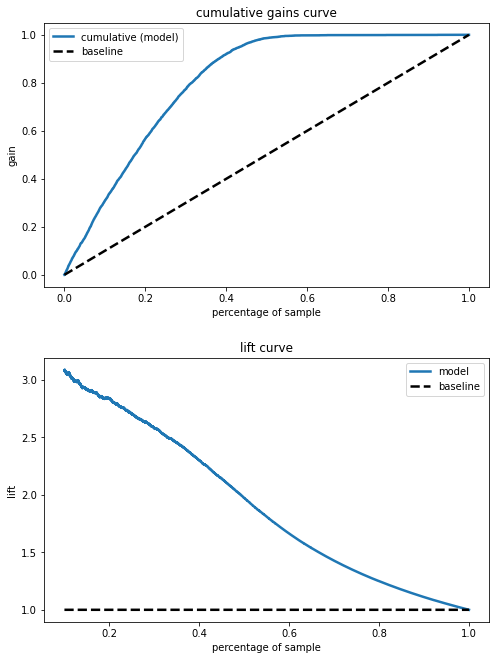

In [105]:
table_xgb = gain_lift_curve(yhat_proba, y_val)
metrics_xgb, new_table_xgb = precision_recall_at_k(table_xgb, 12200)
new_table_xgb.to_pickle(model_data+'xgb_table_final.pkl')

In [106]:
new_table_xgb

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.000437,0.999563,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.000771,0.999229,0,no,0.000000,0.000000,0.000066,0.000000,2,0.000000,0.000000
2,0.002803,0.997197,1,yes,0.000268,0.000268,0.000098,2.720289,3,0.333333,0.000268
3,0.005008,0.994992,0,no,0.000000,0.000268,0.000131,2.040217,4,0.250000,0.000268
4,0.005892,0.994108,0,no,0.000000,0.000268,0.000164,1.632173,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999868,0.000132,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122552,1.000000
30485,0.999907,0.000093,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122548,1.000000
30486,0.999958,0.000043,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122544,1.000000
30487,0.999982,0.000018,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122540,1.000000


In [107]:
metrics_xgb

(0.2818032786885246, 0.9202355460385439)